# Dependencies

In [1]:
from sys import path
path.append('src/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from math import ceil
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from src.mrk_file import MRKFile
from src.iso_standard import PhotographicRequirements
from src.utils.plot import plot_confusion_matrix
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model, Input

Using TensorFlow backend.


In [2]:
FILE_TRAIN_DUMP = 'data/train_dump.pkl'
FILE_TRAIN_BOTTLENECKS = 'data/train_bottlenecks.pkl'

FILE_VAL_DUMP = 'data/val_dump.pkl'
FILE_VAL_BOTTLENECKS = 'data/val_bottlenecks.pkl'

INPUT_SHAPE = (224, 224, 3)

In [3]:
output_names = ['blurred', 
                'looking_away', 
                'ink_marked_creased', 
                'unnatural_skin_tone', 
                'too_dark_light', 
                'washed_out', 
                'pixelation', 
                'hair_across_eyes', 
                'eyes_closed', 
                'varied_background', 
                'roll_pitch_yaw', 
                'flash_reflection_on_skin', 
                'red_eyes', 
                'shadows_behind_head', 
                'shadows_across_face', 
                'dark_tinted_lenses', 
                'flash_reflection_on_lenses', 
                'frames_too_heavy', 
                'frame_covering_eyes', 
                'hat_cap', 
                'veil_over_face', 
                'mouth_open', 
                'presence_of_other_faces_or_toys']

# Helper Methods 

In [4]:
def history_to_dataframe(history, epoch=-1):
    loss_train = np.array([history[name + '_loss'][epoch] for name in output_names])
    loss_val = np.array([history['val_' + name + '_loss'][epoch] for name in output_names])
    acc_train = np.array([history[name + '_acc'][epoch] for name in output_names]) * 100
    acc_val = np.array([history['val_' + name + '_acc'][epoch] for name in output_names]) * 100

    data = np.concatenate(([loss_train], [loss_val], [acc_train], [acc_val]), axis=0).T
    return pd.DataFrame(data, columns=['loss_train', 'loss_val', 'acc_train', 'acc_val'], index=output_names)

def load_proportions(file_txt):
    prop_values = np.loadtxt(file_txt)
    return pd.DataFrame(prop_values, index=output_names).T

def plot_graph(subplot, train, val, title):
    plt.subplot(*subplot)
    plt.plot(train, label='train')
    plt.plot(val, label='val')
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend()

def save_history(history, output_file):
    n_epochs = len(history['loss'])
    n_graphs = len(output_names) * 2
    n_cols = 2
    n_rows = ceil(n_graphs / n_cols)

    df_train_props = load_proportions('data/train_max_proportions.txt')
    df_val_props = load_proportions('data/val_max_proportions.txt')
    
    plt.figure(figsize=(16, 100))
    for i, name in zip(range(1, n_graphs, 2), output_names):
        train_loss = history[name + '_loss']
        train_acc = history[name + '_acc']
        val_loss = history['val_' + name + '_loss']
        val_acc = history['val_' + name + '_acc']

        plot_graph((n_rows, n_cols, i), train_loss, val_loss, '{} ({})'.format(name, 'loss'))
        plot_graph((n_rows, n_cols, i + 1), train_acc, val_acc, '{} ({})'.format(name, 'acc'))
        plt.hlines(df_train_props[name], 0, n_epochs, linestyle=':', color='blue')
        plt.hlines(df_val_props[name], 0, n_epochs, linestyle=':', color='orange')

    plt.tight_layout()
    plt.savefig(output_file)
    plt.close()
    
def save_heatmaps(y_trues, y_preds, output_file, figsize=(20, 20)):
    plt.figure(figsize=figsize)

    n_graphs = len(output_names)
    n_cols = 5
    n_rows = ceil(n_graphs / n_cols)
    labels = np.unique(y_trues)

    for i, name, y_true, y_pred in zip(range(1, n_graphs + 1), output_names, y_trues, y_preds):
        y_pred = np.argmax(y_pred, axis=-1)
        conf_matrix = confusion_matrix(y_true.ravel(), y_pred, labels=labels)

        plt.subplot(n_rows, n_cols, i)
        plot_confusion_matrix(conf_matrix, 
                              target_names=['D', 'NC', 'C'], 
                              title=name, 
                              normalize=True)
    plt.savefig(output_file)
    plt.close()

# Load Data 

In [5]:
train_image_files, x_train, train_mrks = pkl.load(open(FILE_TRAIN_DUMP, 'rb'))

print(len(train_image_files), type(train_image_files))
print(x_train.shape, x_train.dtype)
print(len(train_mrks), type(train_mrks[0]))

5211 <class 'list'>
(5211, 224, 224, 3) float32
5211 <class 'src.mrk_file.MRKFile'>


In [6]:
val_image_files, x_val, val_mrks = pkl.load(open(FILE_VAL_DUMP, 'rb'))

print(len(val_image_files), type(val_image_files))
print(x_val.shape, x_val.dtype)
print(len(val_mrks), type(val_mrks[0]))

565 <class 'list'>
(565, 224, 224, 3) float32
565 <class 'src.mrk_file.MRKFile'>


# Save Bottlenecks 

In [7]:
base_model = MobileNet(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

In [8]:
train_features = base_model.predict(x_train, batch_size=32, verbose=1)
val_features = base_model.predict(x_val, batch_size=32, verbose=1)

print(train_features.shape, train_features.dtype)
print(val_features.shape, val_features.dtype)

565/565 [==============================] - 1s 1ms/step
(5211, 7, 7, 1024) float32
(565, 7, 7, 1024) float32


In [9]:
train_values = np.array([mrk.photo_reqs.values() for mrk in train_mrks], dtype=np.int8)
val_values = np.array([mrk.photo_reqs.values() for mrk in val_mrks], dtype=np.int8)

print(train_values.shape, train_values.dtype)
print(val_values.shape, val_values.dtype)

(5211, 23) int8
(565, 23) int8


In [10]:
pkl.dump((train_features, train_values), open(FILE_TRAIN_BOTTLENECKS, 'wb'), protocol=-1)
pkl.dump((val_features, val_values), open(FILE_VAL_BOTTLENECKS, 'wb'), protocol=-1)

# Transfer Learning 

In [5]:
train_features, train_values = pkl.load(open(FILE_TRAIN_BOTTLENECKS, 'rb'))
val_features, val_values = pkl.load(open(FILE_VAL_BOTTLENECKS, 'rb'))

print(train_features.shape, train_features.dtype)
print(train_values.shape, train_values.dtype)
print(val_features.shape, val_features.dtype)
print(val_values.shape, val_values.dtype)

(5211, 7, 7, 1024) float32
(5211, 23) int8
(565, 7, 7, 1024) float32
(565, 23) int8


In [6]:
# encode reqs values from [-1, 0, 1] => [0, 1, 2]
enc = LabelEncoder()
enc.fit(train_values.ravel())

y_train = enc.transform(train_values.ravel()).reshape(train_values.shape)
y_val = enc.transform(val_values.ravel()).reshape(val_values.shape)

assert(y_train.shape == train_values.shape)
assert(y_val.shape == val_values.shape)
assert(np.all(y_train == train_values + 1))
assert(np.all(y_val == val_values + 1))

In [7]:
def dropout_dense_layer(inputs, name):
    r = Dropout(rate=0.5)(inputs)
    return Dense(units=3, activation='softmax', name=name)(r)

In [8]:
inputs = Input(shape=train_features.shape[1:], name='inputs')
avg_pool = GlobalAveragePooling2D()(inputs)

r2 = dropout_dense_layer(avg_pool, name=output_names[0])
r3 = dropout_dense_layer(avg_pool, name=output_names[1])
r4 = dropout_dense_layer(avg_pool, name=output_names[2])
r5 = dropout_dense_layer(avg_pool, name=output_names[3])
r6 = dropout_dense_layer(avg_pool, name=output_names[4])
r7 = dropout_dense_layer(avg_pool, name=output_names[5])
r8 = dropout_dense_layer(avg_pool, name=output_names[6])
r9 = dropout_dense_layer(avg_pool, name=output_names[7])
r10 = dropout_dense_layer(avg_pool, name=output_names[8])
r11 = dropout_dense_layer(avg_pool, name=output_names[9])
r12 = dropout_dense_layer(avg_pool, name=output_names[10])
r13 = dropout_dense_layer(avg_pool, name=output_names[11])
r14 = dropout_dense_layer(avg_pool, name=output_names[12])
r15 = dropout_dense_layer(avg_pool, name=output_names[13])
r16 = dropout_dense_layer(avg_pool, name=output_names[14])
r17 = dropout_dense_layer(avg_pool, name=output_names[15])
r18 = dropout_dense_layer(avg_pool, name=output_names[16])
r19 = dropout_dense_layer(avg_pool, name=output_names[17])
r20 = dropout_dense_layer(avg_pool, name=output_names[18])
r21 = dropout_dense_layer(avg_pool, name=output_names[19])
r22 = dropout_dense_layer(avg_pool, name=output_names[20])
r23 = dropout_dense_layer(avg_pool, name=output_names[21])
r24 = dropout_dense_layer(avg_pool, name=output_names[22])

model = Model(inputs=inputs, 
              outputs=[r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15, r16, r17, r18, r19, r20, r21, r22, r23, r24], 
              name='icaonet')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 7, 7, 1024)   0                                            
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1024)         0           inputs[0][0]                     
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1024)         0           global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 1024)         0           global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dropout_3 

Train on 5211 samples, validate on 565 samples
Epoch 1/3
 - 4s - loss: 6.0478 - blurred_loss: 0.3429 - looking_away_loss: 0.6083 - ink_marked_creased_loss: 0.0822 - unnatural_skin_tone_loss: 0.1488 - too_dark_light_loss: 0.1554 - washed_out_loss: 9.0763e-05 - pixelation_loss: 0.2157 - hair_across_eyes_loss: 0.1814 - eyes_closed_loss: 0.4292 - varied_background_loss: 0.2152 - roll_pitch_yaw_loss: 0.5419 - flash_reflection_on_skin_loss: 0.3095 - red_eyes_loss: 0.3261 - shadows_behind_head_loss: 0.4972 - shadows_across_face_loss: 0.2936 - dark_tinted_lenses_loss: 0.1700 - flash_reflection_on_lenses_loss: 0.2952 - frames_too_heavy_loss: 0.1717 - frame_covering_eyes_loss: 0.3566 - hat_cap_loss: 0.2218 - veil_over_face_loss: 0.0537 - mouth_open_loss: 0.4279 - presence_of_other_faces_or_toys_loss: 0.0034 - blurred_acc: 0.8699 - looking_away_acc: 0.7588 - ink_marked_creased_acc: 0.9660 - unnatural_skin_tone_acc: 0.9438 - too_dark_light_acc: 0.9516 - washed_out_acc: 1.0000 - pixelation_acc: 0.9

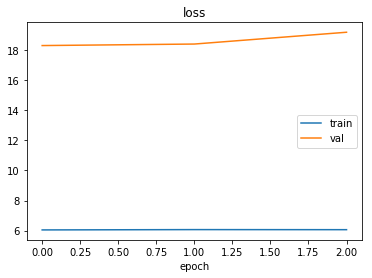

In [30]:
hist = model.fit(train_features, 
                 np.hsplit(y_train, range(1, y_train.shape[1])), 
                 batch_size=32, 
                 epochs=3, 
                 validation_data=(val_features, np.hsplit(y_val, range(1, y_val.shape[1]))), 
                 verbose=2)

save_history(hist.history, 'images/history.pdf')

plot_graph((1, 1, 1), hist.history['loss'], hist.history['val_loss'], 'loss')
plt.savefig('images/loss.pdf')

In [31]:
history_to_dataframe(hist.history)

,loss_train,loss_val,acc_train,acc_val
blurred,0.341263,0.294242,87.334485,87.610619
looking_away,0.614337,0.702454,75.724429,79.469027
ink_marked_creased,0.074000,0.104652,96.756860,94.159292
unnatural_skin_tone,0.139893,2.312552,94.684322,71.150442
too_dark_light,0.142336,0.791758,95.029745,87.964602
washed_out,0.000308,0.969954,99.980810,93.982301
pixelation,0.229585,0.218213,93.014776,94.867257
hair_across_eyes,0.194210,1.023546,92.362310,91.504425
eyes_closed,0.429214,0.601103,84.321627,87.610619
varied_background,0.216405,2.283364,91.460372,82.654867


In [9]:
y_trues = np.hsplit(y_val, range(1, y_val.shape[1]))
y_preds = model.predict(val_features)

save_heatmaps(y_trues, y_preds, output_file='images/heatmaps.pdf')